# Predicting house sale prices with a random forest model
Given enough data, it should be possible to teach a model to recognize and weight the factors that determine the sale price of a given house. In this project, I train a random forest model to predict sale prices as accurately as possible. The dataset is from Kaggle (https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data).

In [6]:
#Import the libraries we'll be needing later
import math
import random
import numpy as np
import pandas as pd
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import partial_dependence
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [ ]:
#Load data
trainandvalid = pd.read_csv('drive/MyDrive/Houses/train.csv')
test = pd.read_csv('drive/MyDrive/Houses/test.csv')

In [ ]:
#Identify dependent variable (sale price of each house)
depvar = 'SalePrice'
trainandvalid[depvar] = np.log(trainandvalid[depvar])

In [ ]:
%%capture
#Teach the model the appropriate order of all ordinal categorical columns (in this case mainly quality estimations of various features of the house, 
#which should be treated as ranked from Excellent to Poor instead of just looking at Excellent and Poor as two equal categories)
orders = {
    'ExterQual': ['Ex', 'Gd', 'TA', 'Fa', 'Po'],
    'ExterCond': ['Ex', 'Gd', 'TA', 'Fa', 'Po'],
    'BsmtQual': ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
    'BsmtCond': ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
    'BsmtExposure': ['Gd', 'Av', 'Mn', 'No', 'NA'],
    'BsmtFinType1': ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA'],
    'BsmtFinType2': ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA'],
    'HeatingQC': ['Ex', 'Gd', 'TA', 'Fa', 'Po'],
    'KitchenQual': ['Ex', 'Gd', 'TA', 'Fa', 'Po'],
    'Functional': ['Typ','Min1','Min2', 'Mod','Maj1','Maj2','Sev','Sal'],
    'FireplaceQu': ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
    'GarageFinish': ['Fin', 'RFn', 'Unf', 'NA'],
    'GarageCond': ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
    'GarageQual': ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
    'PoolQC': ['Ex', 'Gd', 'TA', 'Fa', 'Po']
    }

for var in orders:
  trainandvalid[var] = trainandvalid[var].astype('category')
  trainandvalid[var].cat.set_categories(orders[var], ordered=True, inplace=True)
  test[var] = test[var].astype('category')
  test[var].cat.set_categories(orders[var], ordered=True, inplace=True)

In [ ]:
#Basic transformations (replacing missing values with median values and replacing string values with numeric values):
procs = [Categorify, FillMissing]

In [ ]:
#Splitting continuous and categorical variables so the model knows which is which
cont = [
    'LotFrontage',
    'LotArea',
    'OverallQual',
    'OverallCond',
    'YearBuilt',
    'YearRemodAdd',
    'MasVnrArea',
    'BsmtFinSF1',
    'BsmtFinSF2',
    'BsmtUnfSF',
    'TotalBsmtSF',
    '1stFlrSF',
    '2ndFlrSF',
    'LowQualFinSF',
    'GrLivArea',
    'GarageYrBlt',
    'GarageArea',
    'WoodDeckSF',
    'OpenPorchSF',
    'EnclosedPorch',
    '3SsnPorch',
    'ScreenPorch',
    'PoolArea',
    'MiscVal',
    'BedroomAbvGr',
    'KitchenAbvGr',
    'TotRmsAbvGrd',
    'BsmtFullBath', 
    'BsmtHalfBath', 
    'FullBath', 
    'HalfBath', 
    'Fireplaces',
    'GarageCars'
]

cat = list(set(trainandvalid.columns).difference(set(cont)))
cat.remove(depvar)

In [ ]:
#Splitting the training data into a training set and a validation set
train_idx = random.sample(range(trainandvalid.shape[0]), int(trainandvalid.shape[0] / 1.25))
valid_idx = [n for n in range(trainandvalid.shape[0]) if n not in train_idx]
splits = (list(train_idx), list(valid_idx))

In [ ]:
#Create training/validation TabularPandas object
data = TabularPandas(trainandvalid, procs, cat, cont, y_names=depvar, splits=splits)
save_pickle('drive/MyDrive/Houses/housedata.pkl', data)

In [9]:
#Load data
data = load_pickle('drive/MyDrive/Houses/housedata.pkl')

In [11]:
tx = data.train.xs
ty = data.train.y
vx = data.valid.xs
vy = data.valid.y

In [ ]:
#Create test TabularPandas object
testdata = TabularPandas(test, procs, cat, cont)
save_pickle('drive/MyDrive/Houses/housetestdata.pkl', testdata)

In [ ]:
testdata = load_pickle('drive/MyDrive/Houses/housetestdata.pkl')

In [66]:
#Model hyperparameters:
hyperparameters = {
    'n_estimators': 135,
    'max_samples': 0.54,
    'max_features': 30,
    'min_samples_leaf': 2,
    'max_depth': 5
}

In [21]:
#Set up Random Forest model
def randomforest(x,y):
  model = RandomForestRegressor(hyperparameters['n_estimators'], max_samples=hyperparameters['max_samples'], max_features=hyperparameters['max_features'], min_samples_leaf=hyperparameters['min_samples_leaf'], n_jobs=2, oob_score=True).fit(x,y)
  return model

In [23]:
model = randomforest(tx, ty)

In [26]:
#RMSE training/validation loss function
def loss(x, y, model):
  preds = model.predict(x)
  return round(math.sqrt(((preds-y)**2).mean()), 6)

In [ ]:
(loss(tx, ty), loss(vx, vy))

(0.127819, 0.13977)

In [32]:
#Out-of-bag loss
def oobloss(model, y):
  return round(math.sqrt(((model.oob_prediction_-y)**2).mean()), 6)

oobloss(model, ty)

0.180871

Our first Random Forest model produced an average validation loss of about 0.15, which is reasonable (a version converting low cardinality continuous values to categorical values returned 0.16 so that code has been discarded). Our out-of-bag error (OOB) is equal to our validation error, which suggests that we are not overfitting to the validation set. Now let's see if we can improve the model.

In [ ]:
#First, let's check to see if the test set has special properties that might need to be taken into account
zeros = [0] * trainandvalid.shape[0]
ones = [1] * test.shape[0]

trainandvalid['istest'] = zeros
test['istest'] = ones

all = pd.concat([trainandvalid.drop('SalePrice', axis=1), test])
depvar = 'istest'

alldata = TabularPandas(all, procs, cat, cont, y_names=depvar, splits=splits)
allmodel = RandomForestRegressor(110, max_samples=0.4, max_features=int(math.sqrt(len(alldata))), min_samples_leaf=6, n_jobs=2).fit(alldata.train.xs, alldata.train.y)

(loss(alldata.train.xs, alldata.train.y), loss(alldata.valid.xs, alldata.valid.y))

In [ ]:
#Loss was 12 for both training and validation set. Now to compare with completely random values:
randombinary = list(np.random.randint(0,2, size=all.shape[0]))
all['istest'] = randombinary

depvar = 'istest'

alldata = TabularPandas(all, procs, cat, cont, y_names=depvar, splits=splits)
allmodel = RandomForestRegressor(110, max_samples=0.4, max_features=int(math.sqrt(len(alldata))), min_samples_leaf=6, n_jobs=2).fit(alldata.train.xs, alldata.train.y)

(loss(alldata.train.xs, alldata.train.y), loss(alldata.valid.xs, alldata.valid.y))

#Conclusion: Loss is actually slightly lower when predicting random numbers than when predicting
#whether an item is in the test set or the training set. I don't understand why it's lower but the fact that it isn't higher
#suggests that there is nothing different about the test set compared to the training set, which is good
#because it means a model trained on our training set will likely apply to it.

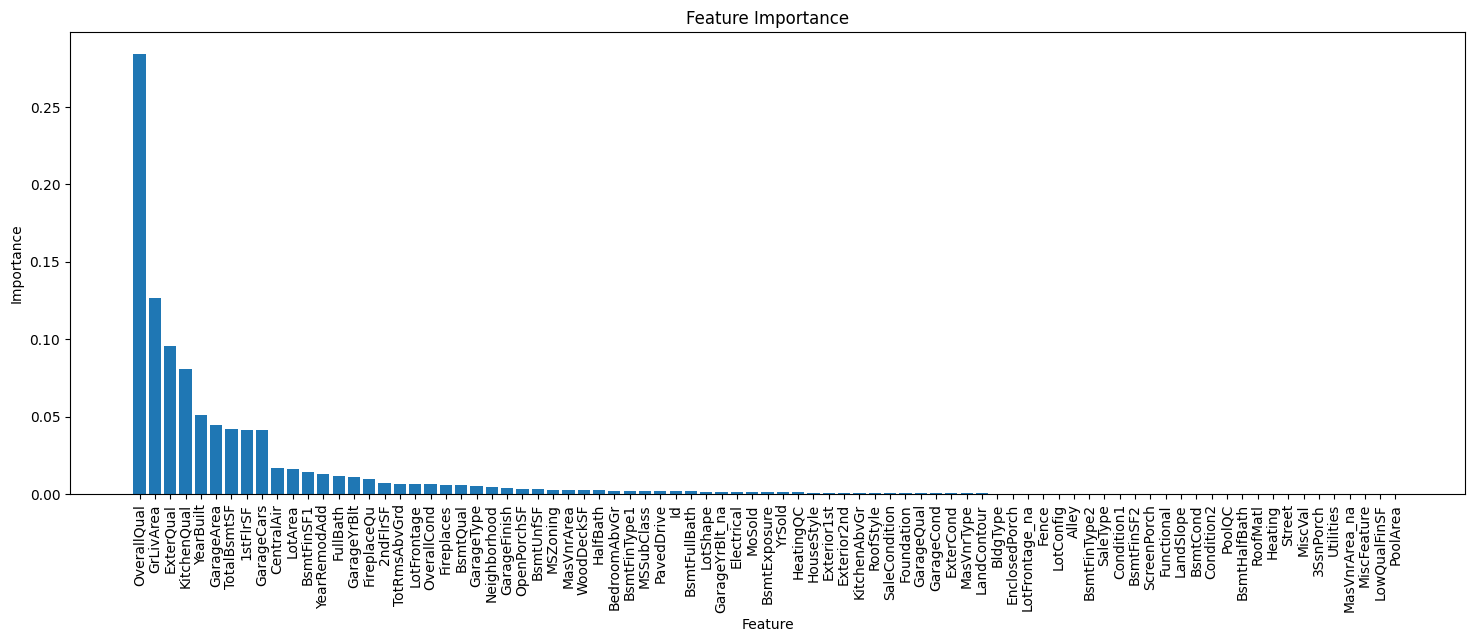

In [ ]:
#Now let's see if we have some redundant variables:
features = pd.DataFrame({'feature': tx.columns, 'importance': model.feature_importances_}).sort_values('importance', ascending=False)

import matplotlib.pyplot as plt

# Plot the sorted DataFrame as a bar chart
plt.figure(figsize=(18, 6))
plt.bar(features["feature"], features["importance"])

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Set labels and title
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importance")

# Display the bar chart
plt.show()

As expected, a few variables are doing the heavy lifting. Let's see what happens if we ignore all variables whose predictive power is less than the ID of the item.

In [ ]:
features.set_index('feature', inplace=True)
features.loc['Id']

importance    0.001888
Name: Id, dtype: float64

In [ ]:
to_keep = list(features[features.importance>0.001888].index.values)
leantx = tx[to_keep]
leanvx = vx[to_keep]
leantest = testdata[to_keep]

In [ ]:
leanmodel = randomforest(leantx, ty)

In [ ]:
(loss(leantx, ty, model=leanmodel), loss(leanvx, vy, model=leanmodel))

(0.127156, 0.138936)

In [ ]:
oobloss(leanmodel, ty)

0.153369

Loss remained more or less the same but should generalize better. Now let's check for strongly correlated variables.

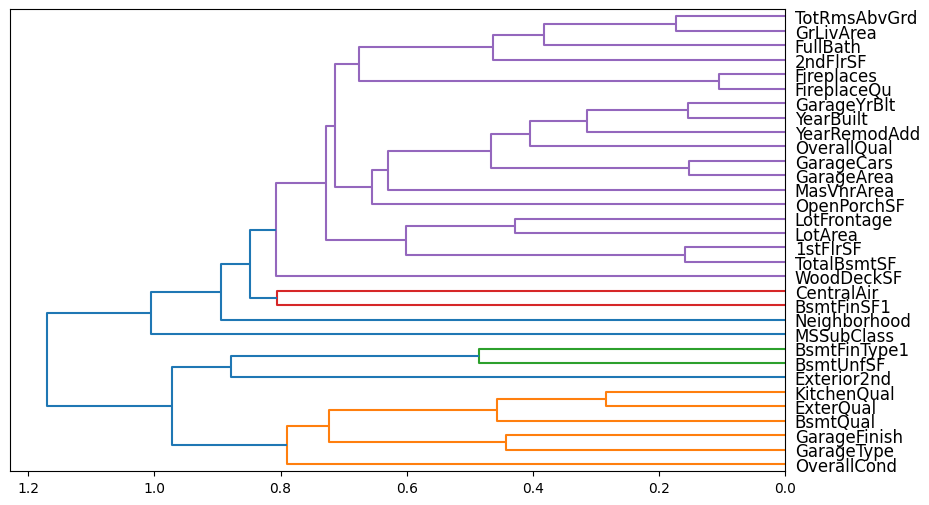

In [ ]:
#This function by Sylvain Gugger, taken from FastAI's docs
from scipy.cluster import hierarchy as hc

def cluster_columns(df, figsize=(10,6), font_size=12):
    corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method='average')
    fig = plt.figure(figsize=figsize)
    hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=font_size)
    plt.show()

cluster_columns(leantx)

Although there don't seem to be any fully correlated variables, some of them, such as fireplaces/fireplace quality and house year built/garage year built, are - expectedly - quite closely correlated. Let's see what happens if we remove one of each pair.

In [ ]:
leanmodel.oob_score_

0.8487891579488893

In [ ]:
{v: randomforest(leantx.drop(v, axis=1), ty).oob_score_ for v in ['Fireplaces', 'FireplaceQu', 'GarageYrBlt', 'YearBuilt', 'GarageCars', 'GarageArea', '1stFlrSF', 'TotalBsmtSF', 'TotRmsAbvGrd', 'GrLivArea']}

{'Fireplaces': 0.8470841133439128,
 'FireplaceQu': 0.8494291955998405,
 'GarageYrBlt': 0.847290016906457,
 'YearBuilt': 0.8487127696357126,
 'GarageCars': 0.8495376573963862,
 'GarageArea': 0.8519628938310315,
 '1stFlrSF': 0.8501466539810423,
 'TotalBsmtSF': 0.8473331493408222,
 'TotRmsAbvGrd': 0.8516371155730488,
 'GrLivArea': 0.8424867960363315}

It looks like removing some of the variables actually makes the model better. Let's check its overall performance without those variables.

In [ ]:
to_drop = ['FireplaceQu', 'GarageArea', '1stFlrSF', 'TotRmsAbvGrd']
leantx = leantx.drop(to_drop, axis=1)
leanvx = leanvx.drop(to_drop, axis=1)
leantest = leantest.drop(to_drop, axis=1)

In [ ]:
leanmodel = randomforest(leantx, ty)

This actually brought the loss down a bit

In [ ]:
save_pickle('drive/MyDrive/Houses/leanmodel.pkl', leanmodel)
save_pickle('drive/MyDrive/Houses/leantx.pkl', leantx)
save_pickle('drive/MyDrive/Houses/leanvx.pkl', leanvx)
save_pickle('drive/MyDrive/Houses/leantest.pkl', leantest)

In [7]:
leanmodel = load_pickle('drive/MyDrive/Houses/leanmodel.pkl')
leantx = load_pickle('drive/MyDrive/Houses/leantx.pkl')
leanvx = load_pickle('drive/MyDrive/Houses/leanvx.pkl')
leantest = load_pickle('drive/MyDrive/Houses/leantest.pkl')

Now let's bring in the test set and make some predictions and see how they look...

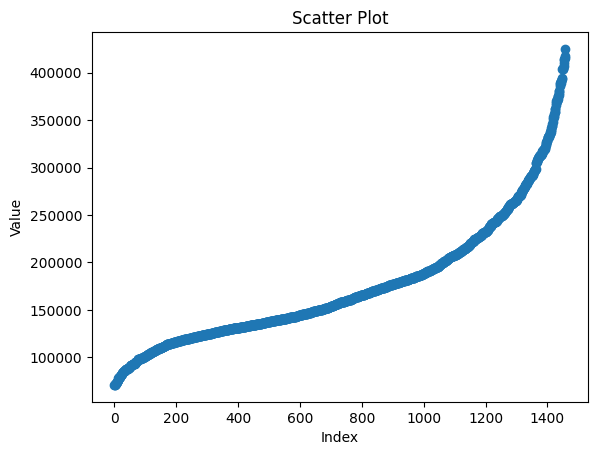

In [ ]:
preds = leanmodel.predict(leantest)

preds = np.sort(preds)

# Generate x-coordinates for the scatter plot (in ascending order)
x = np.arange(len(preds))

# Plot the scatter plot
plt.scatter(x, np.exp(preds))

# Set appropriate labels and title
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Scatter Plot")

# Display the plot
plt.show()

This looks quite reasonable. We don't see predictions plateauing at either end, which would have indicated out-of-domain labels in the test set.
Finally, let's see if we can tune our hyperparameters.

In [ ]:
#Define scoring function
def gridloss(preds, y, **kwargs):
  return round(1-math.sqrt(((preds-y)**2).mean()), 6)

gridscorer = make_scorer(gridloss)

#Define hyperparameter values to test:
searchparams = {
    'n_estimators': [135],
    'max_samples': [0.54],
    'max_features': [25,30],
    'min_samples_leaf': [2,4,6],
    'max_depth': [3,4,5,6,7,8,9,10]
}

gridsearch = GridSearchCV(RandomForestRegressor(), searchparams, scoring=gridscorer)
gridsearch.fit(leantx, ty)

The first grid search returned 0.51 for max_samples, 5 for min_samples_leaf and 120 for n_estimators. Since these are minimal or maximal values for every parameter, I'll adjust the parameter ranges and try again.
The second grid search returned 0.54 for max_samples, 2 for min_samples_leaf and 135 for n_estimators and 30 for max_features. Validation loss is now down from 0.15 to 0.13. I'll freeze some of the parameters, narrow down the search area for some others, and add in the final parameter, max_depth.

In [54]:
gridsearch.best_estimator_

RandomForestRegressor(max_depth=10, max_features=30, max_samples=0.54,
                      min_samples_leaf=2, n_estimators=135)

In [67]:
model = randomforest(leantx, ty)
(loss(leantx, ty, model), loss(leanvx, vy, model), oobloss(model, ty))

(0.091757, 0.128667, 0.14497)

Now with a validation loss of 0.13 and an OOB loss of 0.145, it's time to draw the line and see how well we did. The final hyperparameters are as seen above, except that I chose to set max_depth to 5 instead of 10 because a max_depth of 10 will usually overfit the model and I don't trust GridSearchCV's cross validation on my rather small dataset enough to go with it anyway. Note that there are some more things one could try in order to tweak the accuracy further. These include:

*   Including the min_samples_split hyperparameter as well (gains from this should be marginal though)
*   Looking for anomalies in the test set and adjusting predictions for those
*   Making a confidence estimate for each prediction on the test set and changing low-confidence predictions to a weighted average of the prediction and the expected mean
*   Replacing all categorical variables with entity embeddings acquired by training a neural network on the dataset first. This might bring considerable gains but it would be a major undertaking.
*   Using other models than random forest (such as Gradient Boosting Machines, Deep Learning). Given that there are no categorical variables with very high cardinality and also no free text variables in this dataset, it's unlikely that a neural network would perform considerably better than a random forest, although it might of course perform marginally better.



In [68]:
#Generate predictions for the test set for Kaggle submission:

preds = model.predict(leantest)

ValueError: ignored